In [15]:
!pip install sagemaker pandas boto3 awswrangler --quiet


In [16]:
# AWS Imports
import boto3
from botocore.client import ClientError
import sagemaker
from pyathena import connect
import awswrangler as wr
import pandas as pd
from sagemaker.feature_store.feature_group import FeatureGroup
from time import gmtime, strftime

# Data Transformation Imports
from io import StringIO

# Misc Imports
from IPython.display import display, HTML

In [17]:
# Create a SageMaker session object, which is used to manage interactions with SageMaker resources.
sess = sagemaker.Session()

# Retrieve the default Amazon S3 bucket associated with the SageMaker session.
bucket = sess.default_bucket()

# Get the IAM role associated with the current SageMaker notebook or environment.
role = sagemaker.get_execution_role()

# Get the AWS region name for the current session.
region = boto3.Session().region_name

# Retrieve the AWS account ID of the caller using the Security Token Service (STS) client.
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Create a Boto3 client for the SageMaker service, specifying the AWS region.
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# Create an S3 client
s3 = boto3.client('s3')

featurestore_runtime = boto3.client("sagemaker-featurestore-runtime")

FILE_NAME="data.csv"
DATA_SOURCE="db_source"
DATA_FOLDER =f"s3://{bucket}/aai-540-group-3-final-project/data/"
FILE_LOCATION=f"{DATA_FOLDER}{FILE_NAME}"
DATA_PATH = f"{DATA_FOLDER}{DATA_SOURCE}/"


In [18]:
# Define the Feature Group Schema

feature_group_name = "employee-attrition-feature-store"
record_identifier_name = "Employee ID"  # Unique identifier for each record
event_time_feature_name = "EventTime"  # Required timestamp field

# Define feature group
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sess)


In [19]:
# Load and Prepare Data
file_key = "aai-540-group-3-final-project/data/db_source/data.csv"

# Download the file from S3 to a local file object
response = s3.get_object(Bucket=bucket, Key=file_key)

# Read the content of the file into a pandas DataFrame
data = pd.read_csv(response['Body'])

# Display the DataFrame
display(data)

[02/03/25 05:52:37] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=512134;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=121637;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,16243,56,Female,42,Healthcare,7830,Poor,Medium,Average,0,...,0,Senior,Medium,60,No,No,No,Poor,Medium,Stayed
74494,47175,30,Female,15,Education,3856,Good,Medium,Average,2,...,0,Entry,Medium,20,No,No,No,Good,Medium,Left
74495,12409,52,Male,5,Education,5654,Good,Very High,Below Average,0,...,4,Mid,Small,7,No,No,No,Good,High,Left
74496,9554,18,Male,4,Education,5276,Fair,High,Average,0,...,3,Mid,Large,5,No,No,No,Poor,High,Stayed


In [20]:
# Rename feature names to remove spaces
data.columns = (
    data.columns
    .str.replace(" ", "_")  # Replace spaces with underscores
    .str.replace("-", "_")  # Replace hyphens with underscores (optional)
    .str.replace("/", "_")  # Replace slashes with underscores (optional)
)

# Verify updated column names
print(data.columns)


Index(['Employee_ID', 'Age', 'Gender', 'Years_at_Company', 'Job_Role',
       'Monthly_Income', 'Work_Life_Balance', 'Job_Satisfaction',
       'Performance_Rating', 'Number_of_Promotions', 'Overtime',
       'Distance_from_Home', 'Education_Level', 'Marital_Status',
       'Number_of_Dependents', 'Job_Level', 'Company_Size', 'Company_Tenure',
       'Remote_Work', 'Leadership_Opportunities', 'Innovation_Opportunities',
       'Company_Reputation', 'Employee_Recognition', 'Attrition'],
      dtype='object')


In [21]:
from sagemaker.feature_store.feature_group import FeatureGroup
import pandas as pd
import sagemaker

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()

# Feature Group Name
feature_group_name = "employee-attrition-feature-store"

# Check if Feature Group already exists
try:
    existing_feature_group = sagemaker_session.sagemaker_client.describe_feature_group(
        FeatureGroupName=feature_group_name
    )
    print(f"✅ Feature Group '{feature_group_name}' already exists. Skipping creation.")
except sagemaker_session.sagemaker_client.exceptions.ResourceNotFoundException:
    print(f"🔄 Feature Group '{feature_group_name}' not found. Creating a new one...")

    # Ensure the EventTime column exists and is properly formatted
    data["EventTime"] = pd.to_datetime("now").strftime("%Y-%m-%dT%H:%M:%SZ")

    # Verify EventTime is present
    print(data.columns)  # Check if 'EventTime' appears in the list

    # Ensure Employee ID is properly named
    data.rename(columns={"Employee ID": "Employee_ID"}, inplace=True)

    # Fix all column names to remove spaces
    data.columns = data.columns.str.replace(" ", "_")

    # Verify DataFrame structure before loading to Feature Store
    print(data.head())

    # Initialize Feature Group
    feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker_session)

    # Reload feature definitions after column renaming
    feature_group.load_feature_definitions(data_frame=data)

    # Create Feature Group with corrected names
    feature_group.create(
        record_identifier_name="Employee_ID",  # Ensure matches renamed column
        event_time_feature_name="EventTime",  # Ensure this column exists
        role_arn=role,
        description="Feature store for employee attrition prediction",
        s3_uri=DATA_PATH  # ✅ Required for Offline Store
    )
    print(f"🚀 Feature Group '{feature_group_name}' has been successfully created.")


✅ Feature Group 'employee-attrition-feature-store' already exists. Skipping creation.


In [22]:
feature_group.describe()


{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:095342792399:feature-group/employee-attrition-feature-store',
 'FeatureGroupName': 'employee-attrition-feature-store',
 'RecordIdentifierFeatureName': 'Employee_ID',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'Employee_ID',
   'FeatureType': 'String'},
  {'FeatureName': 'Age', 'FeatureType': 'Integral'},
  {'FeatureName': 'Gender', 'FeatureType': 'String'},
  {'FeatureName': 'Years_at_Company', 'FeatureType': 'Integral'},
  {'FeatureName': 'Job_Role', 'FeatureType': 'String'},
  {'FeatureName': 'Monthly_Income', 'FeatureType': 'Integral'},
  {'FeatureName': 'Work_Life_Balance', 'FeatureType': 'String'},
  {'FeatureName': 'Job_Satisfaction', 'FeatureType': 'String'},
  {'FeatureName': 'Performance_Rating', 'FeatureType': 'String'},
  {'FeatureName': 'Number_of_Promotions', 'FeatureType': 'Integral'},
  {'FeatureName': 'Overtime', 'FeatureType': 'String'},
  {'FeatureName': 'Distance_from_Home', 'FeatureT

In [23]:
# Convert Employee_ID to string
data["Employee_ID"] = data["Employee_ID"].astype(str)

# Convert EventTime to correct format
data["EventTime"] = pd.to_datetime("now").strftime("%Y-%m-%dT%H:%M:%SZ")

# Verify again
print("✅ Data Types After Conversion:\n", data.dtypes)
print("✅ Sample Data After Conversion:\n", data.head())


✅ Data Types After Conversion:
 Employee_ID                 object
Age                          int64
Gender                      object
Years_at_Company             int64
Job_Role                    object
Monthly_Income               int64
Work_Life_Balance           object
Job_Satisfaction            object
Performance_Rating          object
Number_of_Promotions         int64
Overtime                    object
Distance_from_Home           int64
Education_Level             object
Marital_Status              object
Number_of_Dependents         int64
Job_Level                   object
Company_Size                object
Company_Tenure               int64
Remote_Work                 object
Leadership_Opportunities    object
Innovation_Opportunities    object
Company_Reputation          object
Employee_Recognition        object
Attrition                   object
EventTime                   object
dtype: object
✅ Sample Data After Conversion:
   Employee_ID  Age  Gender  Years_at_Company  

In [24]:
# Verify column names and data types before ingestion
print("🔍 Column Names:", data.columns)
print("🔍 Data Types:\n", data.dtypes)
print("🔍 First Few Rows:\n", data.head())


🔍 Column Names: Index(['Employee_ID', 'Age', 'Gender', 'Years_at_Company', 'Job_Role',
       'Monthly_Income', 'Work_Life_Balance', 'Job_Satisfaction',
       'Performance_Rating', 'Number_of_Promotions', 'Overtime',
       'Distance_from_Home', 'Education_Level', 'Marital_Status',
       'Number_of_Dependents', 'Job_Level', 'Company_Size', 'Company_Tenure',
       'Remote_Work', 'Leadership_Opportunities', 'Innovation_Opportunities',
       'Company_Reputation', 'Employee_Recognition', 'Attrition', 'EventTime'],
      dtype='object')
🔍 Data Types:
 Employee_ID                 object
Age                          int64
Gender                      object
Years_at_Company             int64
Job_Role                    object
Monthly_Income               int64
Work_Life_Balance           object
Job_Satisfaction            object
Performance_Rating          object
Number_of_Promotions         int64
Overtime                    object
Distance_from_Home           int64
Education_Level        

In [25]:
# Reload feature definitions with corrected data
feature_group.load_feature_definitions(data_frame=data)

# Ingest data into Feature Store with reduced parallel workers
feature_group.ingest(data_frame=data, max_workers=1, wait=True)


[02/03/25 05:52:38] INFO     Started ingesting index %d to %d                                  ]8;id=263382;file:///opt/conda/lib/python3.11/site-packages/sagemaker/feature_store/feature_group.py\feature_group.py]8;;\:]8;id=523123;file:///opt/conda/lib/python3.11/site-packages/sagemaker/feature_store/feature_group.py#448\448]8;;\

IngestionManagerPandas(feature_group_name='employee-attrition-feature-store', feature_definitions={'Employee_ID': {'FeatureName': 'Employee_ID', 'FeatureType': 'String'}, 'Age': {'FeatureName': 'Age', 'FeatureType': 'Integral'}, 'Gender': {'FeatureName': 'Gender', 'FeatureType': 'String'}, 'Years_at_Company': {'FeatureName': 'Years_at_Company', 'FeatureType': 'Integral'}, 'Job_Role': {'FeatureName': 'Job_Role', 'FeatureType': 'String'}, 'Monthly_Income': {'FeatureName': 'Monthly_Income', 'FeatureType': 'Integral'}, 'Work_Life_Balance': {'FeatureName': 'Work_Life_Balance', 'FeatureType': 'String'}, 'Job_Satisfaction': {'FeatureName': 'Job_Satisfaction', 'FeatureType': 'String'}, 'Performance_Rating': {'FeatureName': 'Performance_Rating', 'FeatureType': 'String'}, 'Number_of_Promotions': {'FeatureName': 'Number_of_Promotions', 'FeatureType': 'Integral'}, 'Overtime': {'FeatureName': 'Overtime', 'FeatureType': 'String'}, 'Distance_from_Home': {'FeatureName': 'Distance_from_Home', 'FeatureT

In [26]:
# Describe the Feature Group to check ingestion status
feature_group.describe()


{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:095342792399:feature-group/employee-attrition-feature-store',
 'FeatureGroupName': 'employee-attrition-feature-store',
 'RecordIdentifierFeatureName': 'Employee_ID',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'Employee_ID',
   'FeatureType': 'String'},
  {'FeatureName': 'Age', 'FeatureType': 'Integral'},
  {'FeatureName': 'Gender', 'FeatureType': 'String'},
  {'FeatureName': 'Years_at_Company', 'FeatureType': 'Integral'},
  {'FeatureName': 'Job_Role', 'FeatureType': 'String'},
  {'FeatureName': 'Monthly_Income', 'FeatureType': 'Integral'},
  {'FeatureName': 'Work_Life_Balance', 'FeatureType': 'String'},
  {'FeatureName': 'Job_Satisfaction', 'FeatureType': 'String'},
  {'FeatureName': 'Performance_Rating', 'FeatureType': 'String'},
  {'FeatureName': 'Number_of_Promotions', 'FeatureType': 'Integral'},
  {'FeatureName': 'Overtime', 'FeatureType': 'String'},
  {'FeatureName': 'Distance_from_Home', 'FeatureT

In [37]:
wr.catalog.create_parquet_table(
    database="retainAI",
    table="employee_table",
    path="s3://sagemaker-us-east-1-095342792399/aai-540-group-3-final-project/data/db_source/",
    columns_types={
        "Employee_ID": "string",
        "Age": "int",
        "Gender": "string",
        "Years_at_Company": "int",
        "Job_Role": "string",
        "Monthly_Income": "int",
        "Work_Life_Balance": "string",
        "Job_Satisfaction": "string",
        "Performance_Rating": "string",
        "Number_of_Promotions": "int",
        "Overtime": "string",
        "Distance_from_Home": "int",
        "Education_Level": "string",
        "Marital_Status": "string",
        "Number_of_Dependents": "int",
        "Job_Level": "string",
        "Company_Size": "string",
        "Company_Tenure": "int",
        "Remote_Work": "string",
        "Leadership_Opportunities": "string",
        "Innovation_Opportunities": "string",
        "Company_Reputation": "string",
        "Employee_Recognition": "string",
        "Attrition": "string",
        "EventTime": "string"
    }
)

print("✅ Athena table 'employee_table' created in database 'retainAI'.")


✅ Athena table 'employee_table' created in database 'retainAI'.


In [38]:
tables = wr.catalog.get_tables(database="retainAI")
print("✅ Tables in 'retainAI':", [t["Name"] for t in tables])


✅ Tables in 'retainAI': ['employee_table']


In [41]:
query = "SELECT * FROM retainAI.employee_table LIMIT 5"

# Execute Athena query
athena_df = wr.athena.read_sql_query(query, database="retainAI")

# Display results
import pandas as pd

# Display the first few rows of the Athena query results
print("✅ Query executed successfully! Displaying results:")
print(athena_df.head())

# Optionally, if running in Jupyter Notebook
from IPython.display import display
display(athena_df)



[02/03/25 06:45:45] INFO     Created CTAS table                                                       ]8;id=51649;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py\_utils.py]8;;\:]8;id=193230;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py#872\872]8;;\
                             "retainAI"."temp_table_706cf235d7434656bef456d85500c9d4"                              

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=448319;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=585989;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=859134;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=479399;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

✅ Query executed successfully! Displaying results:
  employee_id  age  gender  years_at_company    job_role  monthly_income  \
0       37311   58  Female                 5   Education            4950   
1       41832   36  Female                12  Technology            8354   
2       35671   49  Female                17       Media            6264   
3       53020   49    Male                 2   Education            4828   
4       57558   45  Female                 4   Education            4425   

  work_life_balance job_satisfaction performance_rating  number_of_promotions  \
0              Fair           Medium            Average                     0   
1              Good              Low            Average                     0   
2              Poor             High            Average                     1   
3              Poor           Medium            Average                     1   
4              Fair           Medium            Average                     1   

   ..

,employee_id,age,gender,years_at_company,job_role,monthly_income,work_life_balance,job_satisfaction,performance_rating,number_of_promotions,...,job_level,company_size,company_tenure,remote_work,leadership_opportunities,innovation_opportunities,company_reputation,employee_recognition,attrition,eventtime
0,37311,58,Female,5,Education,4950,Fair,Medium,Average,0,...,Senior,Small,22,Yes,No,No,Good,High,Stayed,2025-02-03T05:52:38Z
1,41832,36,Female,12,Technology,8354,Good,Low,Average,0,...,Mid,Medium,46,No,No,No,Poor,High,Left,2025-02-03T05:52:38Z
2,35671,49,Female,17,Media,6264,Poor,High,Average,1,...,Mid,Medium,88,No,No,No,Fair,Medium,Left,2025-02-03T05:52:38Z
3,53020,49,Male,2,Education,4828,Poor,Medium,Average,1,...,Entry,Large,21,No,No,No,Good,High,Stayed,2025-02-03T05:52:38Z
4,57558,45,Female,4,Education,4425,Fair,Medium,Average,1,...,Entry,Medium,82,No,No,No,Good,Medium,Left,2025-02-03T05:52:38Z


In [46]:
import awswrangler as wr

# Create the staging and production databases
wr.catalog.create_database("retainAI_staging")
wr.catalog.create_database("retainAI_prod")

print("✅ Staging and Production databases created successfully.")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 import awswrangler as wr                                                                     │
│   2                                                                                              │
│   3 # Create the staging and production databases                                                │
│ ❱ 4 wr.catalog.create_database("retainAI_staging")                                               │
│   5 wr.catalog.create_database("retainAI_prod")                                                  │
│   6                                                                                              │
│   7 print("✅ Staging and Production databases created successfully.")                           │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/awswrangler/_config.py:712 in wrapper                    │
│                                                                                                  │
│   709 │   │   │   │   keywords: dict[str, Any] = args[name]                                      │
│   710 │   │   │   │   del args[name]                                                             │
│   711 │   │   │   │   args = {**args, **keywords}                                                │
│ ❱ 712 │   │   return function(**args)                                                            │
│   713 │                                                                                          │
│   714 │   wrapper.__doc__ = _inject_config_doc(doc=function.__doc__, available_configs=availab   │
│   715 │   wrapper.__name__ = function.__name__                                                   │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/awswrangler/catalog/_create.py:712 in create_database    │
│                                                                                                  │
│    709 │   try:                                                                                  │
│    710 │   │   r = client_glue.get_database(**_catalog_id(catalog_id=catalog_id, Name=name))     │
│    711 │   │   if not exist_ok:                                                                  │
│ ❱  712 │   │   │   raise exceptions.AlreadyExists(f"Database {name} already exists and <exist_o  │
│    713 │   │   for k, v in args.items():                                                         │
│    714 │   │   │   if v != r["Database"].get(k, ""):                                             │
│    715 │   │   │   │   client_glue.update_database(**_catalog_id(catalog_id=catalog_id, Name=na  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AlreadyExists: Database retainAI_staging already exists and <exist_ok> is set to False.

In [62]:
import awswrangler as wr
import pandas as pd

# ✅ Correct CSV path
csv_path = "s3://sagemaker-us-east-1-095342792399/aai-540-group-3-final-project/data/db_source/data.csv"

# ✅ Define Parquet paths for Staging & Production
staging_parquet_path = "s3://sagemaker-us-east-1-095342792399/athena/staging/employee_table/"
prod_parquet_path = "s3://sagemaker-us-east-1-095342792399/athena/prod/employee_table/"

# 1️⃣ Load CSV and Fix Column Names
df = wr.s3.read_csv(csv_path)

# ✅ Print column names to check for inconsistencies
print("🔍 Column Names in CSV:", df.columns.tolist())

# ✅ Clean column names by stripping spaces and replacing unexpected characters
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_").str.replace("/", "_")

# ✅ Convert Employee_ID to STRING (Fix the error)
if "Employee_ID" in df.columns:
    df["Employee_ID"] = df["Employee_ID"].astype(str)
else:
    raise KeyError("❌ Column 'Employee_ID' not found in CSV. Check the column names.")

# ✅ Fix EventTime column to ensure it is properly formatted
df["EventTime"] = pd.to_datetime("now").strftime("%Y-%m-%dT%H:%M:%SZ")

# ✅ Verify EventTime is correctly populated
print("✅ Sample Data After Fixing EventTime:\n", df[["Employee_ID", "EventTime"]].head())

# Save as Parquet for Staging
wr.s3.to_parquet(df=df, path=staging_parquet_path, dataset=True, mode="overwrite")
print(f"✅ CSV converted to Parquet with corrected schema and saved at: {staging_parquet_path}")

# Save as Parquet for Production
wr.s3.to_parquet(df=df, path=prod_parquet_path, dataset=True, mode="overwrite")
print(f"✅ CSV converted to Parquet with corrected schema and saved at: {prod_parquet_path}")

# 2️⃣ Register Employee Table in Athena (Staging)
wr.catalog.create_parquet_table(
    database="retainAI_staging",
    table="employee_table",
    path=staging_parquet_path,
    columns_types={
        "Employee_ID": "string",
        "Age": "int",
        "Gender": "string",
        "Years_at_Company": "int",
        "Job_Role": "string",
        "Monthly_Income": "int",
        "Work_Life_Balance": "string",
        "Job_Satisfaction": "string",
        "Performance_Rating": "string",
        "Number_of_Promotions": "int",
        "Overtime": "string",
        "Distance_from_Home": "int",
        "Education_Level": "string",
        "Marital_Status": "string",
        "Number_of_Dependents": "int",
        "Job_Level": "string",
        "Company_Size": "string",
        "Company_Tenure": "int",
        "Remote_Work": "string",
        "Leadership_Opportunities": "string",
        "Innovation_Opportunities": "string",
        "Company_Reputation": "string",
        "Employee_Recognition": "string",
        "Attrition": "string",
        "EventTime": "string"  # ✅ Ensure EventTime is treated as a string for Athena
    }
)

# 3️⃣ Register Employee Table in Athena (Production)
wr.catalog.create_parquet_table(
    database="retainAI_prod",
    table="employee_table",
    path=prod_parquet_path,
    columns_types={
        "Employee_ID": "string",
        "Age": "int",
        "Gender": "string",
        "Years_at_Company": "int",
        "Job_Role": "string",
        "Monthly_Income": "int",
        "Work_Life_Balance": "string",
        "Job_Satisfaction": "string",
        "Performance_Rating": "string",
        "Number_of_Promotions": "int",
        "Overtime": "string",
        "Distance_from_Home": "int",
        "Education_Level": "string",
        "Marital_Status": "string",
        "Number_of_Dependents": "int",
        "Job_Level": "string",
        "Company_Size": "string",
        "Company_Tenure": "int",
        "Remote_Work": "string",
        "Leadership_Opportunities": "string",
        "Innovation_Opportunities": "string",
        "Company_Reputation": "string",
        "Employee_Recognition": "string",
        "Attrition": "string",
        "EventTime": "string"  # ✅ Ensure EventTime is treated as a string for Athena
    }
)

print("✅ Employee table deployed to Staging & Production successfully.")


[02/03/25 07:02:47] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=229446;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=55619;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

🔍 Column Names in CSV: ['Employee ID', 'Age', 'Gender', 'Years at Company', 'Job Role', 'Monthly Income', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Number of Promotions', 'Overtime', 'Distance from Home', 'Education Level', 'Marital Status', 'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition', 'Attrition']
✅ Sample Data After Fixing EventTime:
   Employee_ID             EventTime
0        8410  2025-02-03T07:02:48Z
1       64756  2025-02-03T07:02:48Z
2       30257  2025-02-03T07:02:48Z
3       65791  2025-02-03T07:02:48Z
4       65026  2025-02-03T07:02:48Z
✅ CSV converted to Parquet with corrected schema and saved at: s3://sagemaker-us-east-1-095342792399/athena/staging/employee_table/
✅ CSV converted to Parquet with corrected schema and saved at: s3://sagemaker-us-east-1-095342792399/athena/prod/employee_table/
✅ Employee table de

In [63]:
staging_tables = wr.catalog.get_tables(database="retainAI_staging")
prod_tables = wr.catalog.get_tables(database="retainAI_prod")

print("✅ Tables in 'retainAI_staging':", [t["Name"] for t in staging_tables])
print("✅ Tables in 'retainAI_prod':", [t["Name"] for t in prod_tables])


✅ Tables in 'retainAI_staging': ['employee_table']
✅ Tables in 'retainAI_prod': ['employee_table']


In [64]:
#Query Staging & Production to verify data


query_staging = "SELECT * FROM retainAI_staging.employee_table LIMIT 5"
athena_df_staging = wr.athena.read_sql_query(query_staging, database="retainAI_staging")

query_prod = "SELECT * FROM retainAI_prod.employee_table LIMIT 5"
athena_df_prod = wr.athena.read_sql_query(query_prod, database="retainAI_prod")

print("✅ Staging Data:")
print(athena_df_staging.head())

print("✅ Production Data:")
print(athena_df_prod.head())


[02/03/25 07:02:59] INFO     Created CTAS table                                                       ]8;id=344880;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py\_utils.py]8;;\:]8;id=385352;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py#872\872]8;;\
                             "retainAI_staging"."temp_table_24f6ad8fe7204462a4a683f8137bf9e4"                      

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=856829;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=422227;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=342459;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=321363;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[02/03/25 07:03:02] INFO     Created CTAS table                                                       ]8;id=282261;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py\_utils.py]8;;\:]8;id=192265;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py#872\872]8;;\
                             "retainAI_prod"."temp_table_b49735d6366d40069bd468450f793bc7"                         

[02/03/25 07:03:03] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=338120;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=608245;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=926206;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=353081;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

✅ Staging Data:
  employee_id  age  gender  years_at_company    job_role  monthly_income  \
0        8410   31    Male                19   Education            5390   
1       64756   59  Female                 4       Media            5534   
2       30257   24  Female                10  Healthcare            8159   
3       65791   36  Female                 7   Education            3989   
4       65026   56    Male                41   Education            4821   

  work_life_balance job_satisfaction performance_rating  number_of_promotions  \
0         Excellent           Medium            Average                     2   
1              Poor             High                Low                     3   
2              Good             High                Low                     0   
3              Good             High               High                     1   
4              Fair        Very High            Average                     0   

   ... job_level  company_size company_t

In [66]:
query_staging_count = "SELECT COUNT(*) AS total_rows FROM retainAI_staging.employee_table"
query_prod_count = "SELECT COUNT(*) AS total_rows FROM retainAI_prod.employee_table"

staging_count = wr.athena.read_sql_query(query_staging_count, database="retainAI_staging")
prod_count = wr.athena.read_sql_query(query_prod_count, database="retainAI_prod")

print("✅ Total Rows in Staging:", staging_count.iloc[0]['total_rows'])
print("✅ Total Rows in Production:", prod_count.iloc[0]['total_rows'])


[02/03/25 07:03:37] INFO     Created CTAS table                                                       ]8;id=647521;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py\_utils.py]8;;\:]8;id=900370;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py#872\872]8;;\
                             "retainAI_staging"."temp_table_cb497f51463a49a7af7bbcd66c505687"                      

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=287529;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=405524;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=346808;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=289365;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[02/03/25 07:03:40] INFO     Created CTAS table                                                       ]8;id=127562;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py\_utils.py]8;;\:]8;id=481427;file:///opt/conda/lib/python3.11/site-packages/awswrangler/athena/_utils.py#872\872]8;;\
                             "retainAI_prod"."temp_table_b7a3dc1dc47f46d798e9c8aeafb898a6"                         

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=235480;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=384233;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=243995;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=498100;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

✅ Total Rows in Staging: 74498
✅ Total Rows in Production: 74498


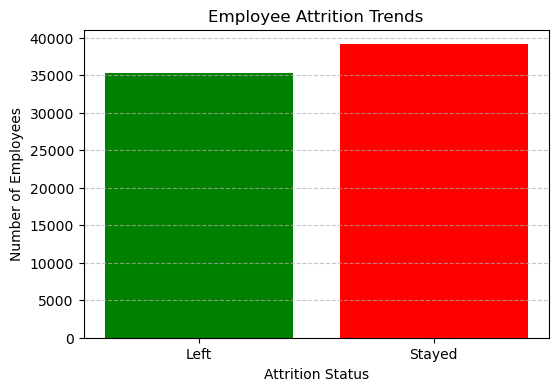

In [74]:
import matplotlib.pyplot as plt

# Create a bar chart for attrition trends
plt.figure(figsize=(6,4))
plt.bar(attrition_df["attrition"], attrition_df["count"], color=["green", "red"])
plt.xlabel("Attrition Status")
plt.ylabel("Number of Employees")
plt.title("Employee Attrition Trends")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [77]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

In [78]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>